# 6imilarité group 2

### Introduction

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import random
import torchvision
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torchvision.transforms as transforms

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.models as models

import time
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda
NVIDIA A2


In [2]:
#!pip install kaggle
# Retrive you kaggle credentials inside your kaggle account and put the kaggle.json file inside /home/onyxia/.kaggle/ 
#!kaggle datasets download jutrera/stanford-car-dataset-by-classes-folder

In [3]:
# Décompresser les données
#with zipfile.ZipFile("data/stanford-car-dataset-by-classes-folder.zip","r") as zip_file:
#    zip_file.extractall("data/")

## Loading and displaying the data

### Useful variables

In [4]:
DATA_PATH = "data/car_data/car_data/"
TRAIN_PATH = "data/car_data/car_data/train"
TEST_PATH = "data/car_data/car_data/test"

### Plot images

In [5]:
def truncate_string(string: str, max_length: int) -> str:
    if len(string) > max_length:
        return string[:max_length - 3] + " [...]"
    else:
        return string

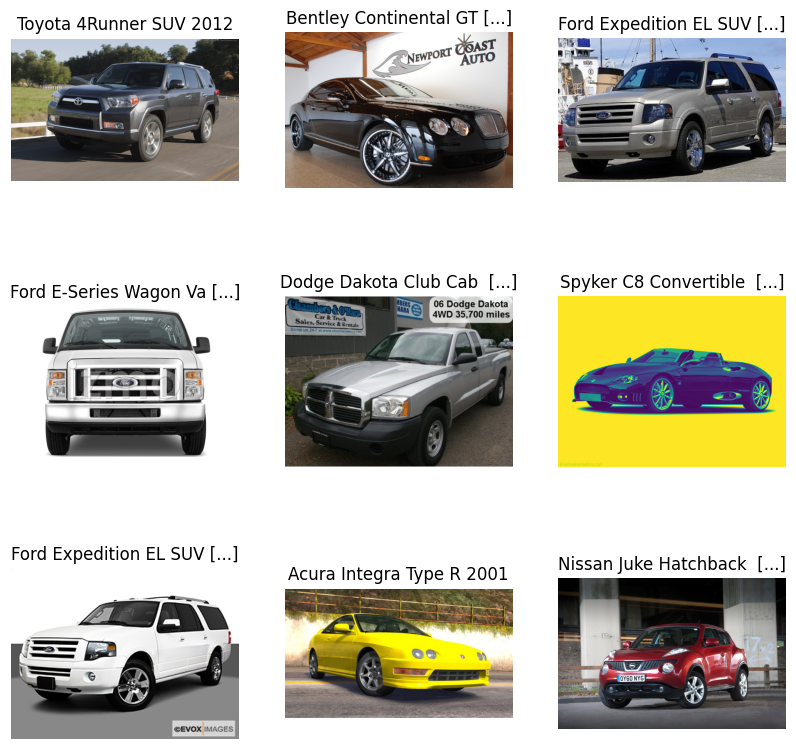

In [6]:
plt.figure(figsize=(10, 10))
classes_directory = random.choices(os.listdir(os.path.join(DATA_PATH, 'train')), k=9)

for i, class_name in enumerate(classes_directory):
    sample_filename = random.choice(os.listdir(os.path.join(DATA_PATH, 'train', class_name)))
    image_path = os.path.join(DATA_PATH, 'train', class_name, sample_filename)
    image = Image.open(image_path)
    
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(truncate_string(class_name, 25))
    plt.axis("off")

### Bar Chart of the class weight in training dataset

In [7]:
car_count_dict = {}

for class_folder in os.listdir(os.path.join(DATA_PATH, 'train')):
    count = len(os.listdir(os.path.join(DATA_PATH, 'train', class_folder)))
    car_count_dict[class_folder] = count

for class_folder in os.listdir(os.path.join(DATA_PATH, 'test')):
    count = len(os.listdir(os.path.join(DATA_PATH, 'test', class_folder)))
    car_count_dict[class_folder] += count

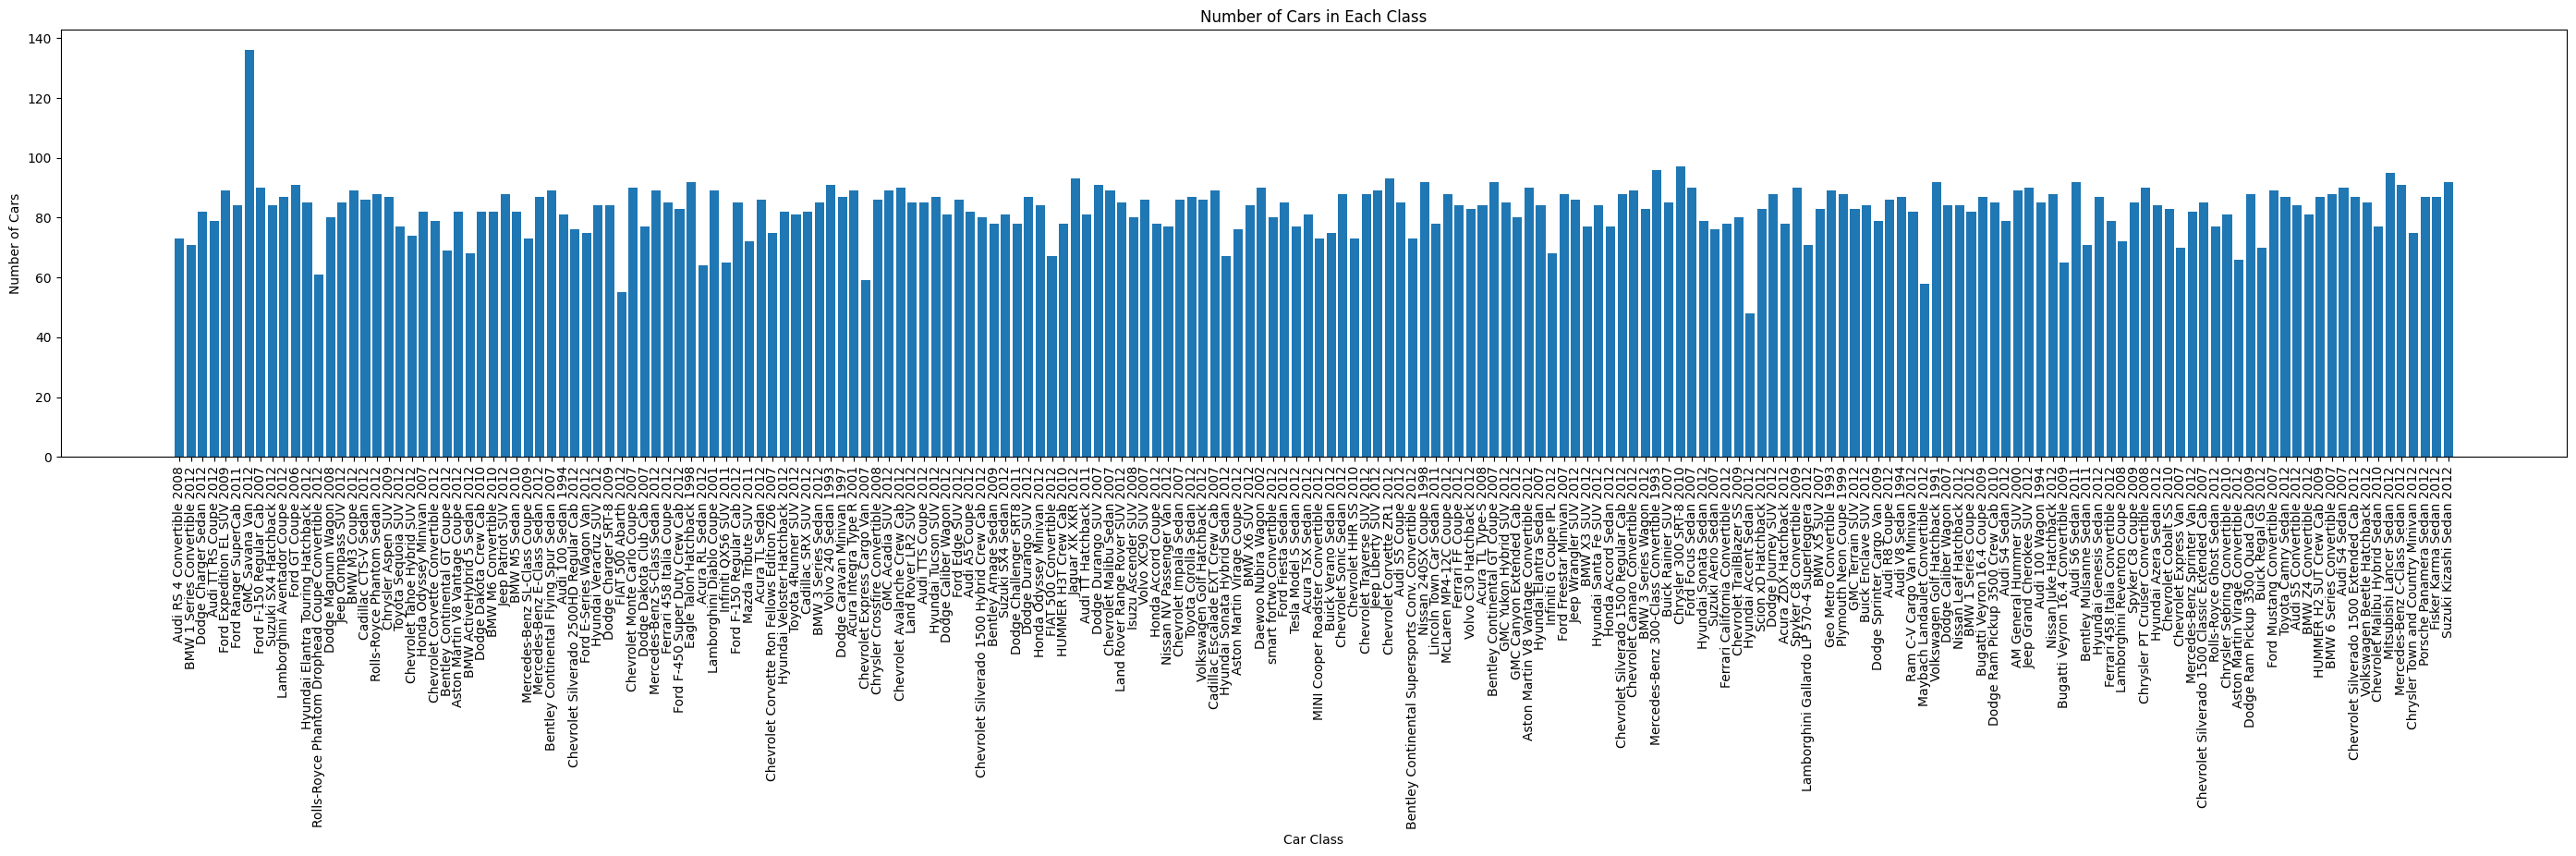

In [8]:
plt.figure(figsize=(35, 6))
plt.bar(car_count_dict.keys(), car_count_dict.values())

plt.xlabel('Car Class')
plt.ylabel('Number of Cars')
plt.title('Number of Cars in Each Class')

plt.xticks(rotation=90)
plt.show()

### Get the average size of images in the training Dataset

In [9]:
height, width = [], []
for class_folder in os.listdir(os.path.join(DATA_PATH, 'train')):
    for image_filename in os.listdir(os.path.join(DATA_PATH, 'train', class_folder)):
        image_path = os.path.join(DATA_PATH, 'train', class_folder, image_filename)
        image = Image.open(image_path)
        height.append(image.height)
        width.append(image.width)

mean_height = round(np.mean(np.array(height)))
mean_width = round(np.mean(np.array(width)))

print(f"{mean_width = }, {mean_height = }")

mean_width = 700, mean_height = 483


## Data augmentation

In [10]:
import multiprocessing

num_cores = multiprocessing.cpu_count()
print(f"{num_cores = }")

num_cores = 104


In [11]:
# Imported from ImageNet
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [12]:
# defining the transformation for the dataset
train_augmentation = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(15),
                                transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

test_augmentation= transforms.Compose([transforms.Resize((224, 224)), #400
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [13]:
train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_PATH, transform = train_augmentation)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle=True, num_workers = num_cores)

test_dataset = torchvision.datasets.ImageFolder(root=TEST_PATH, transform = test_augmentation)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle=False, num_workers = num_cores)

### Training the data

In [14]:
model = models.resnet18(progress=True, pretrained=True)

num_ftrs = model.fc.in_features
no_classes = len(train_dataset.classes)

# Adapt the last dense layer for the 200 avalaible classes
model.fc = nn.Linear(num_ftrs, no_classes)

/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/mamba/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Display thee model architecture

In [15]:
model.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Compute Class weights

In [16]:
# Transform string labels into int labels
counter = 0
label_to_int = {}

for class_name in os.listdir(os.path.join(DATA_PATH, 'train')):
    label_to_int[class_name] = counter
    counter += 1

sample_to_int = []
for class_folder in os.listdir(os.path.join(DATA_PATH, 'train')):
    for _ in os.listdir(os.path.join(DATA_PATH, 'train', class_folder)):
        sample_to_int.append(label_to_int[class_folder])

y = np.array(sample_to_int)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)

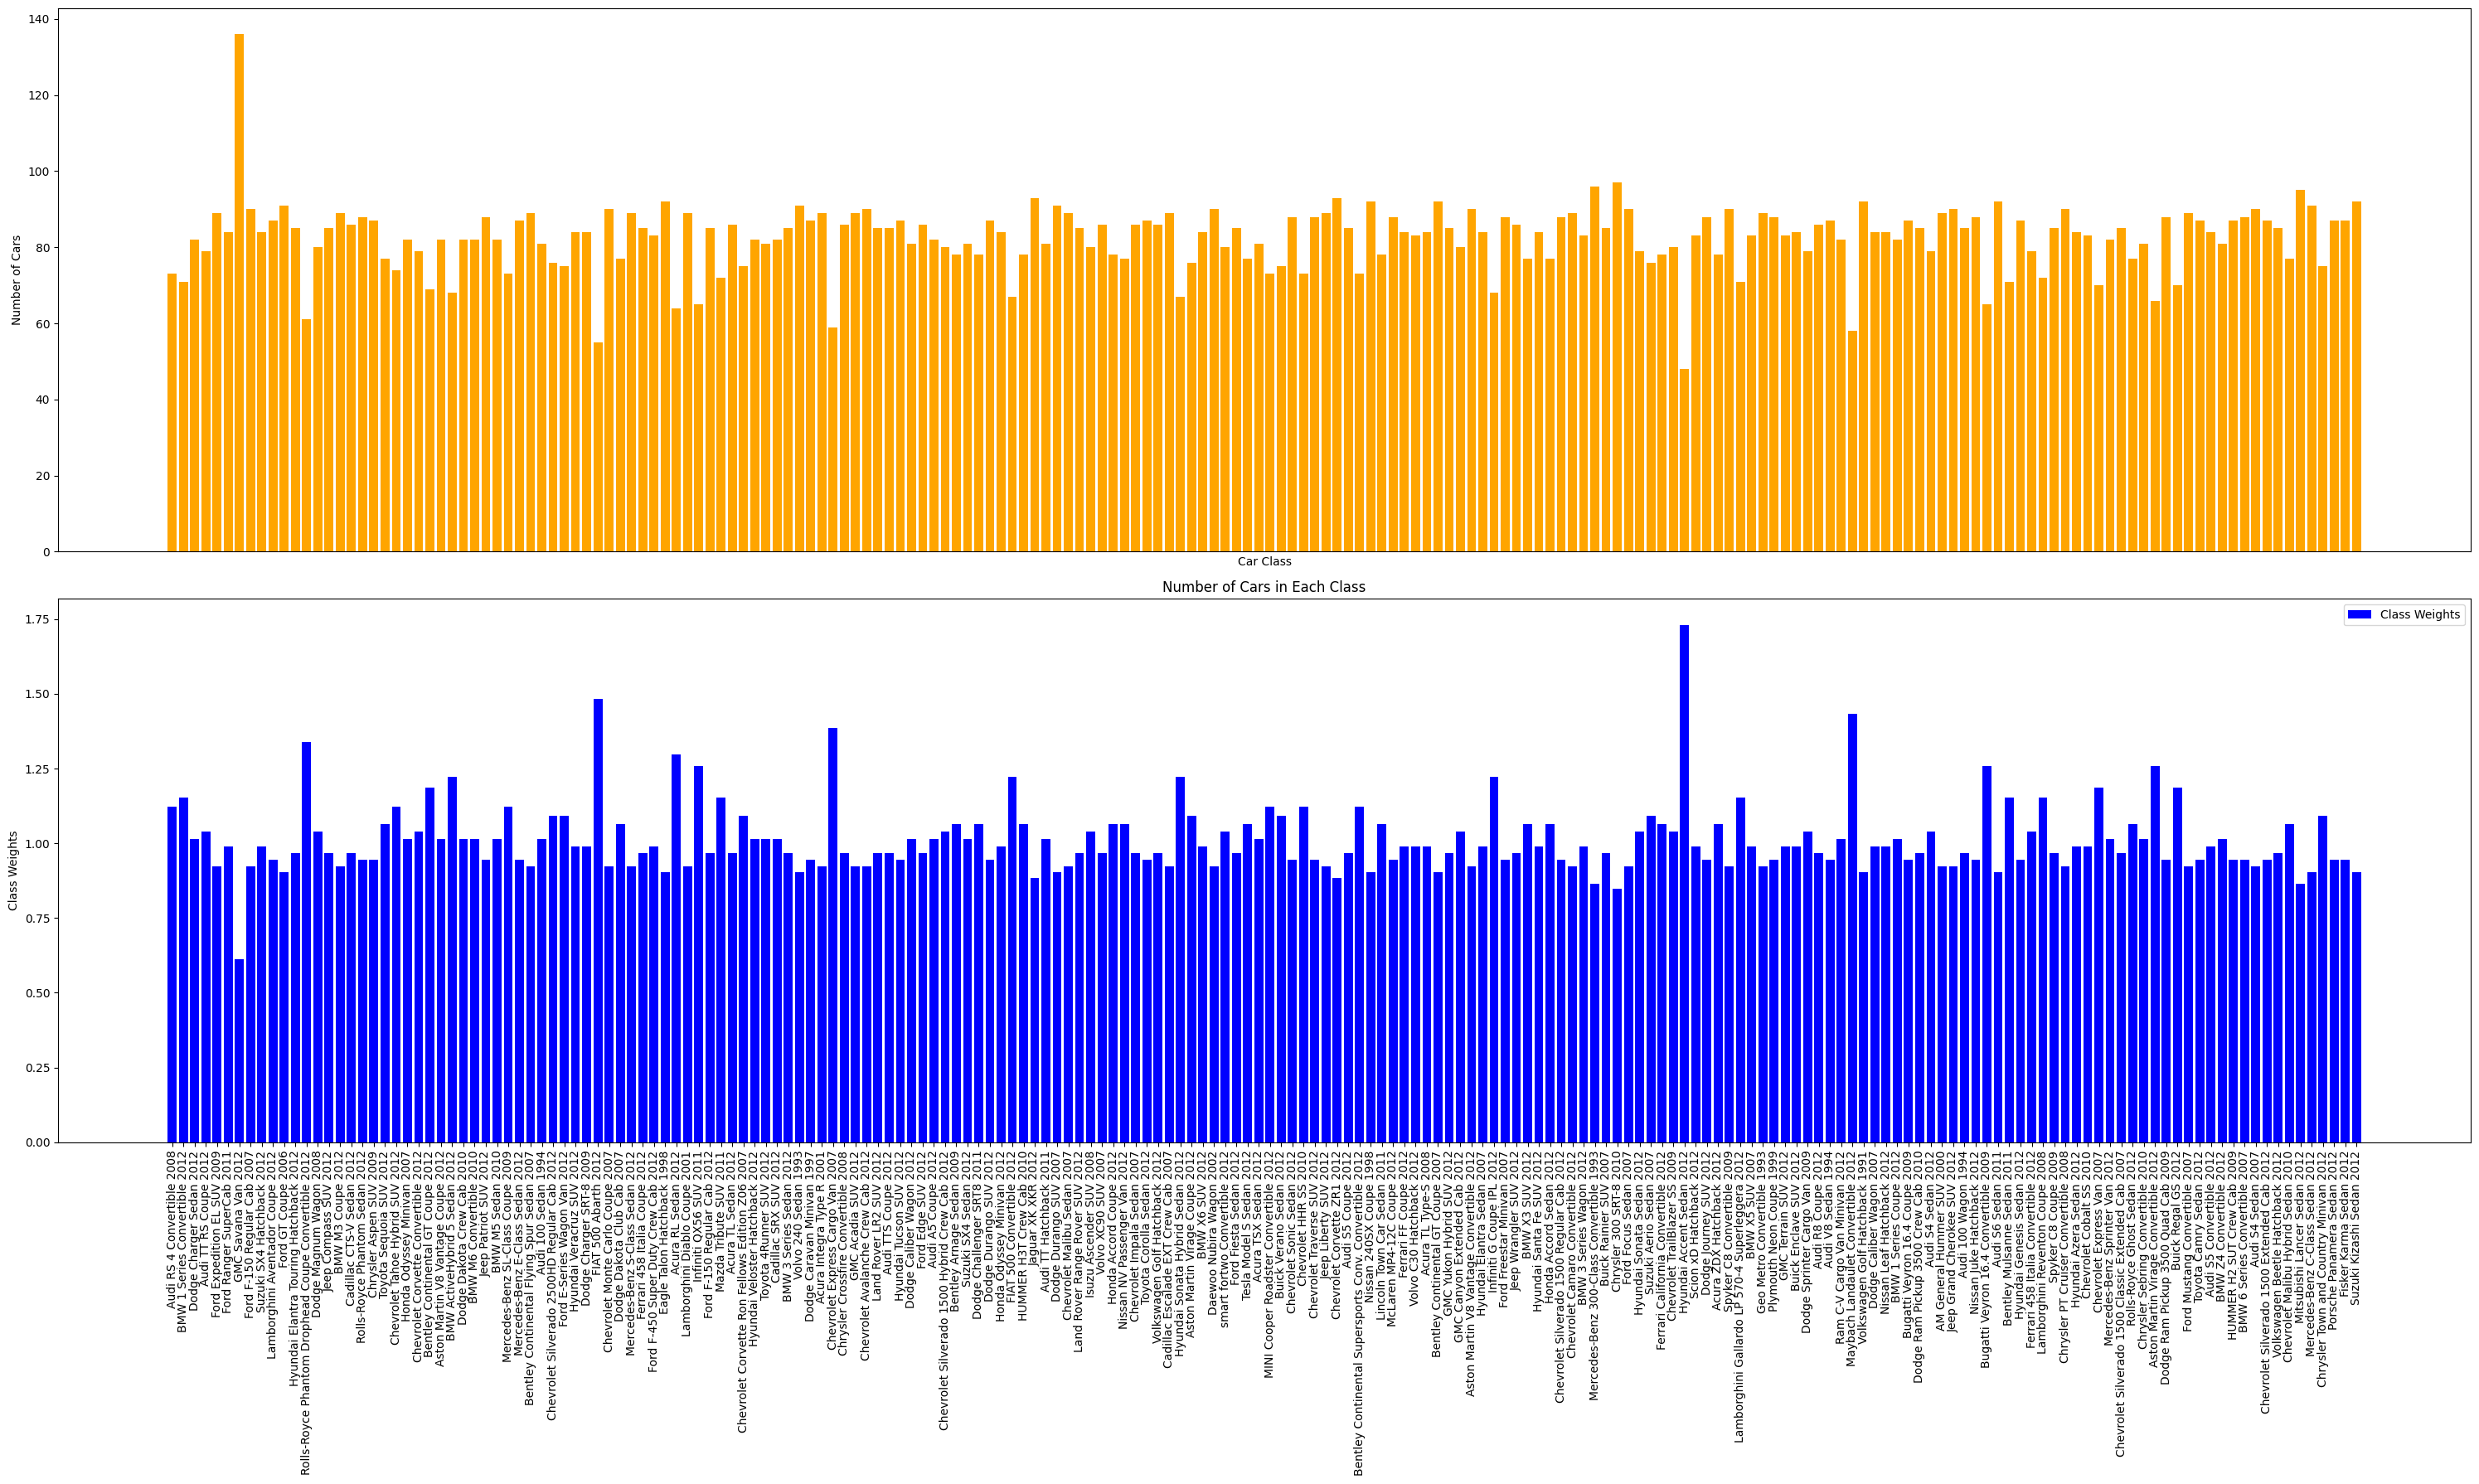

In [17]:
# Create a figure and two subplots side by side
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 18))

# Plot the first bar graph on the first subplot (top)
ax1.bar(car_count_dict.keys(), car_count_dict.values(), color='orange', label='Car Count')
ax1.set_xlabel('Car Class')
ax1.set_ylabel('Number of Cars')
ax1.set_xticks([])

# Plot the second bar graph on the second subplot (bottom)
ax2.bar(car_count_dict.keys(), class_weights, color='blue', label='Class Weights')
ax2.set_ylabel('Class Weights')
ax2.set_title('Number of Cars in Each Class')
ax2.legend()

# Rotate x-axis labels for better visibility
plt.setp(ax2.get_xticklabels(), rotation=90)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
model = model.to(device)

# defining the loss function and the optimizer
class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)
#class_weights = torch.from_numpy(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.02, reduction='mean')
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5) # weight_decay == L2 (riddge)

In [19]:
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)

/opt/mamba/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [23]:
# Evaluate the model via the test dataset and generate predictions.
def eval_model(model, test_loader, device):
    correct = 0.0
    total = 0.0
    running_loss = 0.0

    # Set the model to eval
    model.eval()
    
    # Forward propagation only (no training on test dataset)
    with torch.no_grad():
        for i, data in enumerate(test_loader, 0):
            images, labels = data
            
            # Transfer to GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward propagation
            outputs = model(images)
            
            # Get predictions from the maximum value 
            _, predicted = torch.max(outputs.data, 1)

            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Total number of labels in the test data set
            total += labels.size(0)
            
            # Total correct predictions
            running_loss += loss.item()
            correct += (predicted == labels).sum().item()
    
    # Calculate the accuracy
    test_accuracy = correct / len(test_loader)
    test_loss = running_loss / len(test_loader)
    return test_accuracy, test_loss

In [24]:
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, device, n_epochs = 5):
    losses = []
    accuracies = []
    test_accuracies = []
    test_losses = []
    
    for epoch in tqdm(range(n_epochs)):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0

        # set the model to train mode initially
        # (This is important as some models behave differently in train and test time.)
        model.train()

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data

            # Transfer to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward propagation
            outputs = model(inputs)
            # Get predictions from the maximum value
            _, predicted = torch.max(outputs.data, 1)
            
            # Calculate the loss
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            # Optimize the weights
            optimizer.step()
            
            # Calculate the loss and The accuracy
            running_loss += loss.item()
            running_correct += (labels==predicted).sum().item()
        
        # Compute and appen metric values
        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = running_correct / len(train_loader)
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
                
        test_acc, test_loss = eval_model(model, test_loader, device)
        test_accuracies.append(test_acc)
        test_losses.append(test_loss)

        # Print the data
        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f, test_acc: %.4f, test_loss: %.4f" % (epoch + 1, epoch_duration, epoch_loss, epoch_acc, test_acc, test_loss))
        
        # Adapt the learning rate if needed
        scheduler.step(test_loss)
            
    print('Finished Training')
    return {
        "model": model,
        "accuracies": accuracies,
        "losses": losses,
        "test_accuracies": test_accuracies
    }

In [25]:
n_epochs = 30
# train the model
model, training_losses, training_accs, test_accs = train_model(model, train_loader, 
                            test_loader, criterion, optimizer, lrscheduler, device, n_epochs=n_epochs)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1, duration: 42 s, loss: 4.5035, acc: 4.7304


  3%|▎         | 1/30 [01:00<29:16, 60.57s/it]

Accuracy of the network on the test images: 7 %
Epoch 2, duration: 42 s, loss: 3.7045, acc: 12.9412


  7%|▋         | 2/30 [02:00<28:03, 60.13s/it]

Accuracy of the network on the test images: 12 %
Epoch 3, duration: 42 s, loss: 3.0210, acc: 25.0858


 10%|█         | 3/30 [02:59<26:53, 59.74s/it]

Accuracy of the network on the test images: 24 %
Epoch 4, duration: 42 s, loss: 2.4504, acc: 36.8382


 13%|█▎        | 4/30 [03:59<25:50, 59.63s/it]

Accuracy of the network on the test images: 39 %
Epoch 5, duration: 41 s, loss: 1.9664, acc: 49.6936


 17%|█▋        | 5/30 [04:57<24:41, 59.27s/it]

Accuracy of the network on the test images: 43 %
Epoch 6, duration: 41 s, loss: 1.3271, acc: 69.8897


 20%|██        | 6/30 [05:57<23:42, 59.28s/it]

Accuracy of the network on the test images: 66 %
Epoch 7, duration: 41 s, loss: 1.1377, acc: 76.6054


 23%|██▎       | 7/30 [06:56<22:42, 59.24s/it]

Accuracy of the network on the test images: 68 %
Epoch 8, duration: 42 s, loss: 1.0437, acc: 79.3873


 27%|██▋       | 8/30 [07:56<21:48, 59.47s/it]

Accuracy of the network on the test images: 69 %
Epoch 9, duration: 41 s, loss: 0.9679, acc: 81.4461


 30%|███       | 9/30 [08:55<20:48, 59.47s/it]

Accuracy of the network on the test images: 70 %
Epoch 10, duration: 41 s, loss: 0.8929, acc: 84.2157


 33%|███▎      | 10/30 [09:54<19:45, 59.28s/it]

Accuracy of the network on the test images: 71 %
Epoch 11, duration: 41 s, loss: 0.8836, acc: 84.9632


 37%|███▋      | 11/30 [10:53<18:44, 59.20s/it]

Accuracy of the network on the test images: 71 %
Epoch 12, duration: 41 s, loss: 0.8724, acc: 84.9755


 40%|████      | 12/30 [11:52<17:45, 59.17s/it]

Accuracy of the network on the test images: 71 %
Epoch 13, duration: 41 s, loss: 0.8739, acc: 85.1961


 43%|████▎     | 13/30 [12:51<16:46, 59.19s/it]

Accuracy of the network on the test images: 71 %
Epoch 14, duration: 42 s, loss: 0.8419, acc: 85.9191


 47%|████▋     | 14/30 [13:51<15:50, 59.38s/it]

Accuracy of the network on the test images: 72 %
Epoch 15, duration: 42 s, loss: 0.8487, acc: 85.5515


 50%|█████     | 15/30 [14:51<14:53, 59.60s/it]

Accuracy of the network on the test images: 71 %
Epoch 16, duration: 44 s, loss: 0.8489, acc: 86.0172


 53%|█████▎    | 16/30 [15:53<14:03, 60.26s/it]

Accuracy of the network on the test images: 71 %
Epoch 17, duration: 41 s, loss: 0.8574, acc: 85.4657


 57%|█████▋    | 17/30 [16:53<13:00, 60.02s/it]

Accuracy of the network on the test images: 72 %
Epoch 18, duration: 41 s, loss: 0.8441, acc: 86.1397


 60%|██████    | 18/30 [17:52<11:57, 59.78s/it]

Accuracy of the network on the test images: 72 %
Epoch 19, duration: 41 s, loss: 0.8543, acc: 85.7230


 63%|██████▎   | 19/30 [18:51<10:56, 59.73s/it]

Accuracy of the network on the test images: 72 %
Epoch 20, duration: 42 s, loss: 0.8526, acc: 85.7108


 67%|██████▋   | 20/30 [19:51<09:58, 59.84s/it]

Accuracy of the network on the test images: 72 %
Epoch 21, duration: 42 s, loss: 0.8432, acc: 85.9926


 70%|███████   | 21/30 [20:52<09:00, 60.01s/it]

Accuracy of the network on the test images: 72 %
Epoch 22, duration: 42 s, loss: 0.8394, acc: 86.7525


 73%|███████▎  | 22/30 [21:53<08:02, 60.32s/it]

Accuracy of the network on the test images: 71 %
Epoch 23, duration: 42 s, loss: 0.8513, acc: 85.9069


 77%|███████▋  | 23/30 [22:53<07:01, 60.24s/it]

Accuracy of the network on the test images: 72 %
Epoch 24, duration: 41 s, loss: 0.8434, acc: 86.2500


 80%|████████  | 24/30 [23:52<05:59, 59.98s/it]

Accuracy of the network on the test images: 72 %
Epoch 25, duration: 41 s, loss: 0.8496, acc: 85.6985


 83%|████████▎ | 25/30 [24:51<04:58, 59.63s/it]

Accuracy of the network on the test images: 71 %
Epoch 26, duration: 42 s, loss: 0.8456, acc: 85.9681


 87%|████████▋ | 26/30 [25:51<03:58, 59.75s/it]

Accuracy of the network on the test images: 71 %
Epoch 27, duration: 42 s, loss: 0.8520, acc: 85.7598


 90%|█████████ | 27/30 [26:51<02:59, 59.87s/it]

Accuracy of the network on the test images: 72 %
Epoch 28, duration: 42 s, loss: 0.8489, acc: 86.2500


 93%|█████████▎| 28/30 [27:51<01:59, 59.86s/it]

Accuracy of the network on the test images: 72 %
Epoch 29, duration: 42 s, loss: 0.8456, acc: 86.3848


 93%|█████████▎| 28/30 [28:45<02:03, 61.63s/it]


KeyboardInterrupt: 

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
axs[0].plot(training_losses)
axs[0].set_title("Training Loss")

# Plot training and test accuracy
axs[1].plot(training_accs, label="Training Accuracy")
axs[1].plot(test_accs, label="Test Accuracy")
axs[1].set_title("Training and Test Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()